First I followed <a href="https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8">this</a> to build a model.  This ended up (after automatic feature selection--recursive feature elimination) to not use almost any demographic data to predict high custody level.  

Next, I followed <a href="https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/">this</a> to see if this feature selected model satistifed conditions.

Things I want to do:
1. do the same thing but with manual feature selection (done)
1. do the same thing but with a different number of features to be selected
1. figure out why the data set shrunk so much based on the confusion matrix being much smaller than the original one (done--confusion matrix just based on training data)
1. do the same but with overrides.  Override yes/no and override up yes/no.
1. do the same but with only 2017 data

## Setting up the notebook

In [1]:
import sys
sys.path.append("../../src")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from heatmap import heatmap
import statsmodels.formula.api as smf
import bioinfokit

In [3]:
plt.style.use('ggplot')

In [4]:
from math391.models.logit_models import LogitModelRunner
from math391.preprocessing import preprocess_for_logit
from math391.plotting import roc_plot

In [5]:
%matplotlib inline

from project import rf_models, preprocessing

df = pd.read_csv("../../data/re_custody_2017_gsprs.csv", low_memory=False)



# preprocessing
data = preprocessing.preprocess_input_vars_re(df)

data['high_re_discip_reports'] = np.where(data['re_discip_reports']>2, 1, 0)

data['re_override_up'] = np.where(data['re_ovride_cust_lvl']-data['re_custody_level']>0,1,0)
data['high_re'] = np.where(data['re_custody_level']>3, 1, 0)
print(data.columns)
data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        #"ic_custdy_level",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        "re_escp_hist_2",
        "re_escp_hist_3",
        "re_escp_hist_4",
        "re_escp_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "high_re_discip_reports",
        "high_re"
    ]
]
data = data.dropna()

df_re_all = data

Index(['re_curr_off_cd_1', 're_curr_off_cd_2', 're_curr_off_cd_3',
       're_prev_off_cd_1', 're_prev_off_cd_2', 're_prev_off_cd_3',
       're_escp_hist_1', 're_escp_hist_2', 're_escp_hist_3', 're_escp_hist_4',
       're_escp_hist_5', 're_discip_reports', 're_age_for_class',
       're_instit_violence', 'ic_prior_commits', 'race', 'sex',
       'ethnic_identity', 'citizenship', 'religion', 'legal_zip_code',
       'ic_employ_ind', 'date_of_birth', 're_custody_level', 'ic_custdy_level',
       'control_number', 're_ovride_cust_lvl', 're_de_year', 'off_1_gs_max',
       'off_1_gs_min', 'off_2_gs_max', 'off_2_gs_min', 'off_3_gs_max',
       'off_3_gs_min', 'off_1_prs_max', 'off_1_prs_min', 'off_2_prs_max',
       'off_2_prs_min', 'off_3_prs_max', 'off_3_prs_min', 'marital_status',
       'ic_mrtl_stat_fr_cl', 'age', 'age_gt_45', 'age_lt_25', 'gender_female',
       'race_A', 'race_B', 'race_H', 'race_I', 'race_O', 'prior_commits',
       'escape_hist', 'mrt_stat_  ', 'mrt_stat_   ', 'm

---

## Data exploration

In [6]:
df_re_all['high_re'].value_counts()

0    13811
1     2732
Name: high_re, dtype: int64

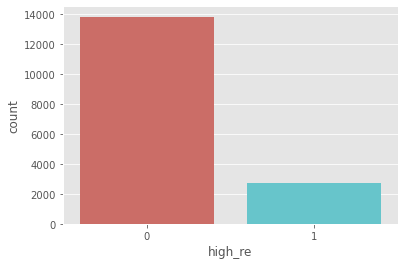

In [7]:
sns.countplot(x='high_re', data=df_re_all, palette='hls')
plt.show()

In [8]:
count_hi = len(df_re_all[df_re_all['high_re']==0])
count_lo = len(df_re_all[df_re_all['high_re']==1])
pct_hi = count_hi/(count_hi+count_lo)
print("percentage of high lev is", pct_hi*100)
pct_lo = count_lo/(count_hi+count_lo)
print("percentage of low lev is", pct_lo*100)

percentage of high lev is 83.48546212899716
percentage of low lev is 16.51453787100284


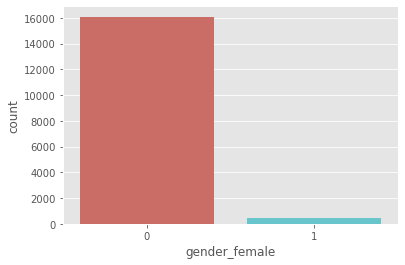

In [9]:
sns.countplot(x='gender_female', data=df_re_all, palette='hls')
plt.show()

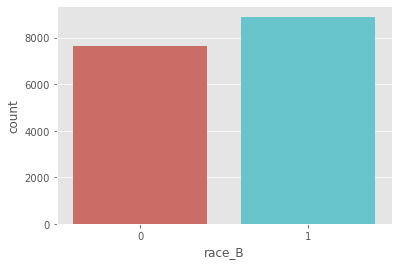

In [10]:
sns.countplot(x='race_B', data=df_re_all, palette='hls')
plt.show()

###  See how quantitative variables vary with custody level

In [11]:
df_re_all.groupby('high_re').mean()['prior_commits']

high_re
0    2.817537
1    3.081991
Name: prior_commits, dtype: float64

In [12]:
df_re_all.groupby('high_re').mean()['off_1_gs_max']

high_re
0    12.101079
1    11.765373
Name: off_1_gs_max, dtype: float64

In [13]:
df_re_all.groupby('high_re').mean()['off_1_prs_max']

high_re
0    2.610021
1    2.597182
Name: off_1_prs_max, dtype: float64

In [14]:
df_re_all.groupby('high_re').mean()['re_discip_reports']

high_re
0    1.704873
1    4.056735
Name: re_discip_reports, dtype: float64

###  See how quantitative variables vary with race_B

In [15]:
df_re_all.groupby('race_B').mean()['re_discip_reports']

race_B
0    2.021711
1    2.154771
Name: re_discip_reports, dtype: float64

In [16]:
df_re_all.groupby('race_B').mean()['off_1_prs_max']

race_B
0    2.461549
1    2.733674
Name: off_1_prs_max, dtype: float64

In [17]:
df_re_all.groupby('race_B').mean()['off_1_gs_max']

race_B
0    11.331284
1    12.659548
Name: off_1_gs_max, dtype: float64

In [18]:
df_re_all.groupby('race_B').mean()['prior_commits']

race_B
0    2.974235
1    2.764078
Name: prior_commits, dtype: float64

###  Visualizations

Text(0, 0.5, 'Count of people')

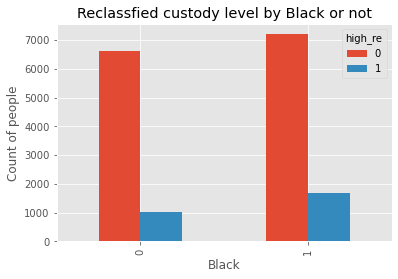

In [19]:
%matplotlib inline
pd.crosstab(df_re_all.race_B,df_re_all.high_re).plot(kind='bar')
plt.title('Reclassfied custody level by Black or not')
plt.xlabel('Black')
plt.ylabel('Count of people')


Text(0, 0.5, 'Proportion of people')

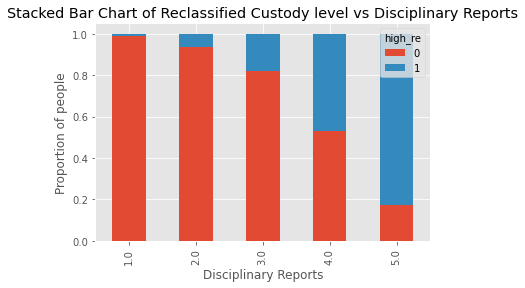

In [20]:
table=pd.crosstab(df_re_all.re_discip_reports,df_re_all.high_re)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Reclassified Custody level vs Disciplinary Reports')
plt.xlabel('Disciplinary Reports')
plt.ylabel('Proportion of people')


Text(0, 0.5, 'Proportion of people')

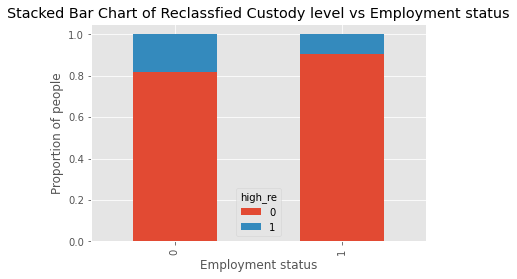

In [21]:
table=pd.crosstab(df_re_all.employed,df_re_all.high_re)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Reclassfied Custody level vs Employment status')
plt.xlabel('Employment status')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

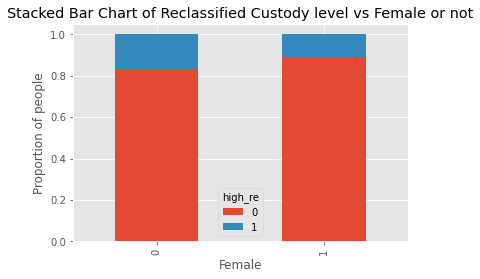

In [22]:
table=pd.crosstab(df_re_all.gender_female,df_re_all.high_re)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Reclassified Custody level vs Female or not')
plt.xlabel('Female')
plt.ylabel('Proportion of people')

---

## Recursive feature elimination

In [23]:
data_final = df_re_all # make a copy

In [24]:
data_final_vars=data_final.columns.values.tolist()

In [25]:
yvars = ['high_re']

In [26]:
Xvars = [i for i in data_final_vars if i not in yvars]

In [27]:
X = data_final.loc[:, data_final.columns != 'high_re']
y = data_final.loc[:, data_final.columns == 'high_re']

In [28]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=300) # increase the number of iterations to get convergence


In [29]:
rfe = RFE(logreg, n_features_to_select=8, step=1)
rfe = rfe.fit(X, y.values.ravel())

In [30]:
print(rfe.support_)

[ True  True  True False  True False False  True False False False  True
 False False  True False False False False False False  True False]


In [31]:
zz= list(zip(Xvars,list(rfe.support_)))

In [32]:
ll = [a for (a,b) in zz if b]

In [33]:
ll

['gender_female',
 'age_gt_45',
 'age_lt_25',
 'race_A',
 'race_O',
 're_discip_reports',
 're_escp_hist_3',
 'employed']

In [37]:
# By comparison, when we did it for IC, we got these variables as most important:  ['age_gt_45',
# 'ic_institut_adj',
# 'escape_hist_4',
# 'escape_hist_5',
# 'mrt_stat_DIV',
# 'mrt_stat_SEP',
# 'mrt_stat_MAR',
# 'mrt_stat_WID']

In [34]:
X = X[ll]


---

## Implementing the model

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.483686
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: -0.079    
Dependent Variable:  high_re          AIC:              16019.2400
Date:                2021-09-30 12:24 BIC:              16080.9497
No. Observations:    16543            Log-Likelihood:   -8001.6   
Df Model:            7                LL-Null:          -7413.0   
Df Residuals:        16535            LLR p-value:      1.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender_female     -1.4467   0.1576  -9.1787 0.0000 -1.7556 -1.1377
age_gt_45         -2.4935   0.0555 -44.9040 0.0000 -2

In [36]:
model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
model_odds

,OR,z-value,2.5%,97.5%
gender_female,0.235355,4.361689e-20,0.172809,0.320540
age_gt_45,0.082620,0.000000e+00,0.074100,0.092120
age_lt_25,0.965737,6.558612e-01,0.828447,1.125777
race_A,0.283001,2.382100e-02,0.094702,0.845705
race_O,0.567432,1.045722e-01,0.286253,1.124805
re_discip_reports,0.982008,2.265892e-02,0.966795,0.997461
re_escp_hist_3,0.996902,9.822685e-01,0.758237,1.310689
employed,0.195734,9.902538e-142,0.172541,0.222045


## Model fitting

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [39]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3878  267]
 [ 254  564]]


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4145
           1       0.68      0.69      0.68       818

    accuracy                           0.90      4963
   macro avg       0.81      0.81      0.81      4963
weighted avg       0.90      0.90      0.90      4963



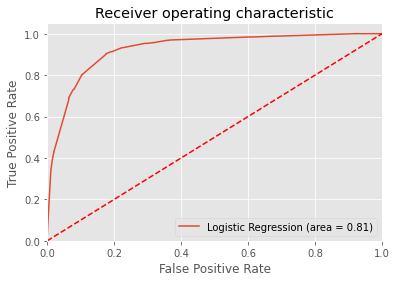

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

---

## Checking conditions

### Balancing features

In [46]:
X = data_final.loc[:, data_final.columns != 'high_re']
y = data_final.loc[:, data_final.columns == 'high_re']
X = X[ll]

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

os

from collections import Counter



ctr = Counter(y['high_re'])

print(ctr)


X_os, y_os = os.fit_resample(X, y)

ctr = Counter(y_os['high_re'])

print(ctr)

logit_model=sm.Logit(y_os,X_os)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)


Counter({0: 13811, 1: 2732})
Counter({0: 13811, 1: 13811})
Optimization terminated successfully.
         Current function value: 0.505178
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.271     
Dependent Variable:  high_re          AIC:              27924.0773
Date:                2021-09-30 12:46 BIC:              27989.8882
No. Observations:    27622            Log-Likelihood:   -13954.   
Df Model:            7                LL-Null:          -19146.   
Df Residuals:        27614            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender_female     -1.4879   0.0993 -14.9877 0.0000 -1.6824 -1

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

os = SMOTE(random_state=0)


X_train_os, y_train_os = os.fit_resample(X_train, y_train)


logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os.values.ravel())

LogisticRegression()

In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3422  723]
 [  82  736]]


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.89      4145
           1       0.50      0.90      0.65       818

    accuracy                           0.84      4963
   macro avg       0.74      0.86      0.77      4963
weighted avg       0.90      0.84      0.85      4963



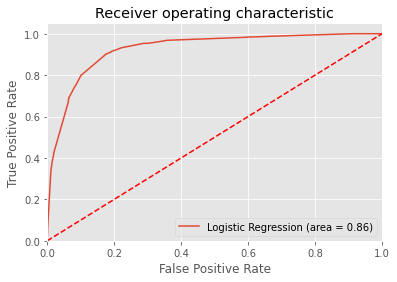

In [51]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Continuous IVs linearly related to log odds

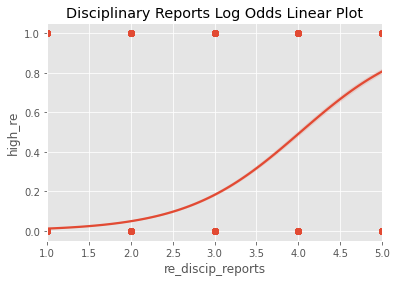

In [52]:
discip = sns.regplot(x= 're_discip_reports', y= 'high_re', data= df_re_all, logistic= True).set_title("Disciplinary Reports Log Odds Linear Plot")
#Looks S-shaped

### Assumption of Absence of Multicollinearity

In [53]:
X.corr()

,gender_female,age_gt_45,age_lt_25,race_A,race_O,re_discip_reports,re_escp_hist_3,employed
gender_female,1.000000,-0.016741,-0.012239,0.000370,0.016783,0.016661,0.002895,0.009524
age_gt_45,-0.016741,1.000000,-0.169842,0.008105,-0.025935,-0.272817,-0.059542,0.066386
age_lt_25,-0.012239,-0.169842,1.000000,-0.003907,-0.007425,0.166646,0.046426,-0.054105
race_A,0.000370,0.008105,-0.003907,1.000000,-0.002610,-0.018367,0.004822,0.000609
race_O,0.016783,-0.025935,-0.007425,-0.002610,1.000000,0.002370,-0.007136,0.018036
re_discip_reports,0.016661,-0.272817,0.166646,-0.018367,0.002370,1.000000,0.068215,-0.081254
re_escp_hist_3,0.002895,-0.059542,0.046426,0.004822,-0.007136,0.068215,1.000000,-0.012626
employed,0.009524,0.066386,-0.054105,0.000609,0.018036,-0.081254,-0.012626,1.000000


In [54]:
# Condition is satisfied because that's what RFE does (I think)
# All in [-.3,.3]

### Assumption of Lack of Outliers

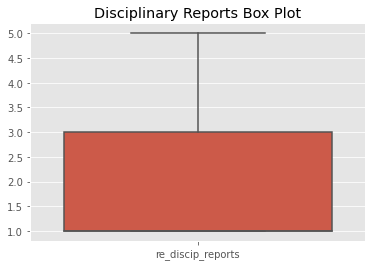

In [56]:
discip_rank_box = sns.boxplot(data= df[['re_discip_reports']]).set_title("Disciplinary Reports Box Plot")
#No outliers

###  Residuals

Based on <a href="https://www.pythonfordatascience.org/logistic-regression-python/#test_with_python">this</a>

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


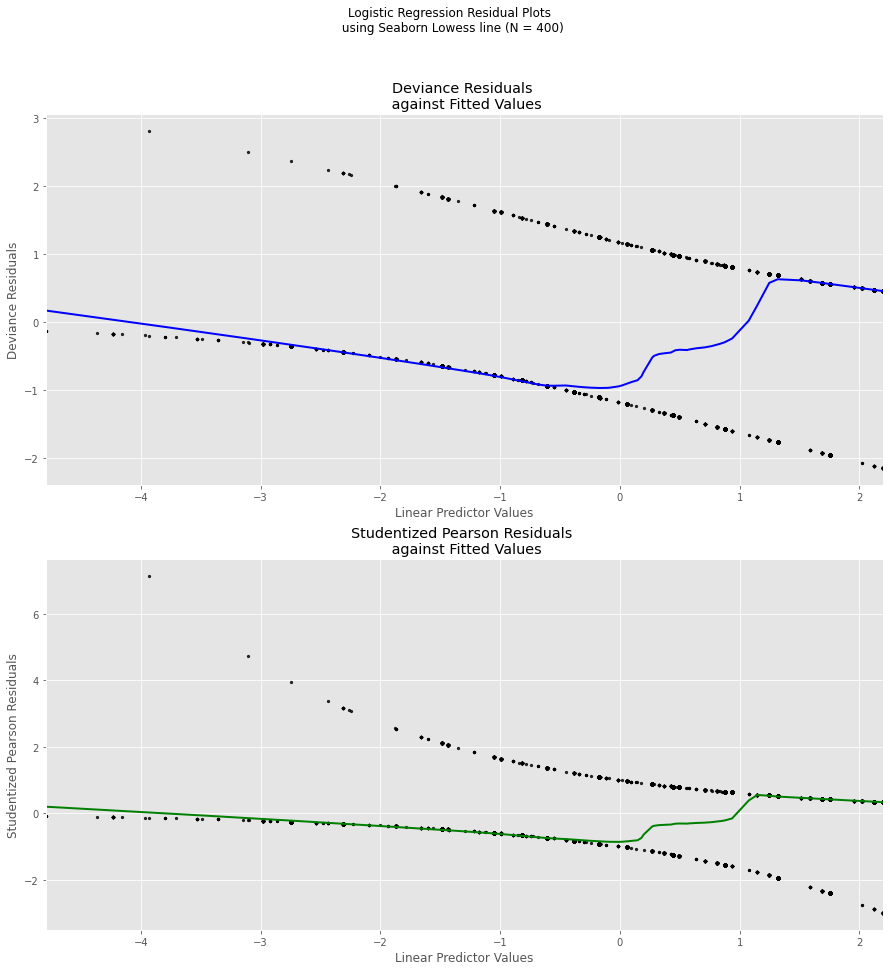

In [57]:
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

In [49]:
# We see that the first line is pretty straight and has y-intercept close to 0

---

## Adding in other variables to control



In [58]:
ll

['gender_female',
 'age_gt_45',
 'age_lt_25',
 'race_A',
 'race_O',
 're_discip_reports',
 're_escp_hist_3',
 'employed']

In [59]:
data_control = data_final

Optimization terminated successfully.
         Current function value: 0.297917
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.335    
Dependent Variable:   high_re          AIC:              9880.8672
Date:                 2021-09-30 12:56 BIC:              9973.4318
No. Observations:     16543            Log-Likelihood:   -4928.4  
Df Model:             11               LL-Null:          -7413.0  
Df Residuals:         16531            LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       7.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender_female     -1.3426   0.1832  -7.3275 0.0000 -1.7017 -0.9835
age_gt_45         -0.9611   0.0685 -14.0287 0.0000 -1

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


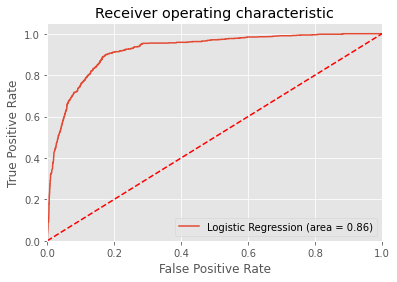

In [61]:
data_control_vars=data_final.columns.values.tolist()
yvars = ['high_re']
Xvars = [i for i in data_final_vars if i not in y]
X = data_control.loc[:, data_control.columns != 'high_re']
y = data_control.loc[:, data_control.columns == 'high_re']
ll = ['gender_female',
 'age_gt_45',
 'age_lt_25',
 'race_A',
 'race_O',
 're_discip_reports',
 're_escp_hist_3',
 'employed']
ll.append('race_B')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
X = X[ll]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

os = SMOTE(random_state=0)


X_train_os, y_train_os = os.fit_resample(X_train, y_train)


logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os.values.ravel())

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


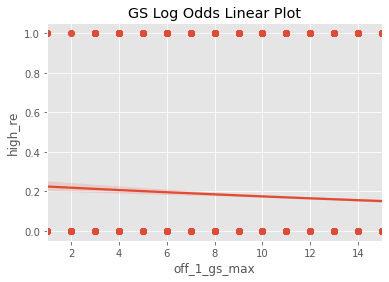

In [62]:
gs = sns.regplot(x= 'off_1_gs_max', y= 'high_re', data= data_control, logistic= True).set_title("GS Log Odds Linear Plot")

plt.show()



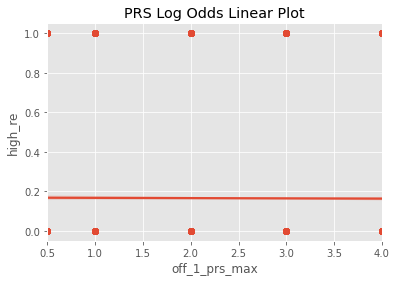

In [63]:
prs = sns.regplot(x= 'off_1_prs_max', y= 'high_re', data= data_control, logistic= True).set_title("PRS Log Odds Linear Plot")

plt.show()

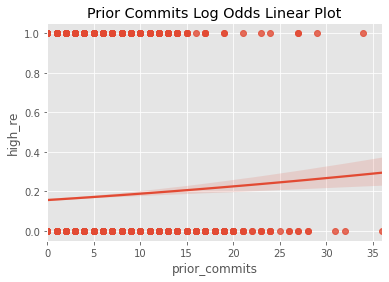

In [64]:
pc = sns.regplot(x= 'prior_commits', y= 'high_re', data= data_control, logistic= True).set_title("Prior Commits Log Odds Linear Plot")

plt.show()

In [55]:
# should be looking for something consistent with an S-shaped curve
# these all seem to have it

In [65]:
data_control[ll].corr()

,gender_female,age_gt_45,age_lt_25,race_A,race_O,re_discip_reports,re_escp_hist_3,employed,race_B,off_1_gs_max,off_1_prs_max,prior_commits
gender_female,1.000000,-0.016741,-0.012239,0.000370,0.016783,0.016661,0.002895,0.009524,-0.044339,-0.029290,-0.054906,-0.013747
age_gt_45,-0.016741,1.000000,-0.169842,0.008105,-0.025935,-0.272817,-0.059542,0.066386,-0.062264,0.124941,0.138055,0.035364
age_lt_25,-0.012239,-0.169842,1.000000,-0.003907,-0.007425,0.166646,0.046426,-0.054105,0.040315,-0.067566,-0.071796,-0.084359
race_A,0.000370,0.008105,-0.003907,1.000000,-0.002610,-0.018367,0.004822,0.000609,-0.049670,0.017433,-0.005964,-0.011111
race_O,0.016783,-0.025935,-0.007425,-0.002610,1.000000,0.002370,-0.007136,0.018036,-0.061155,-0.007865,-0.002958,-0.010479
re_discip_reports,0.016661,-0.272817,0.166646,-0.018367,0.002370,1.000000,0.068215,-0.081254,0.048078,-0.142423,-0.025067,0.094556
re_escp_hist_3,0.002895,-0.059542,0.046426,0.004822,-0.007136,0.068215,1.000000,-0.012626,-0.032052,-0.103168,-0.024033,0.048141
employed,0.009524,0.066386,-0.054105,0.000609,0.018036,-0.081254,-0.012626,1.000000,-0.120572,-0.055822,-0.062837,0.004727
race_B,-0.044339,-0.062264,0.040315,-0.049670,-0.061155,0.048078,-0.032052,-0.120572,1.000000,0.217196,0.116565,-0.031444
off_1_gs_max,-0.029290,0.124941,-0.067566,0.017433,-0.007865,-0.142423,-0.103168,-0.055822,0.217196,1.000000,0.029128,-0.271080


In [57]:
# all are in [-.3, .3]

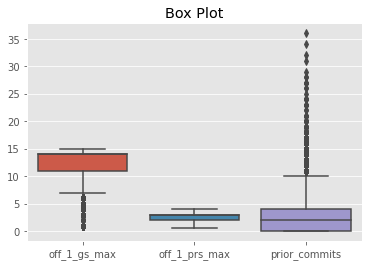

In [66]:
gs_rank_box = sns.boxplot(data= data_control[ll][['off_1_gs_max', 'off_1_prs_max','prior_commits']]).set_title("Box Plot")

plt.show()

In [67]:
data_control['prior_commits'].describe()

count    16543.000000
mean         2.861210
std          3.332257
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         36.000000
Name: prior_commits, dtype: float64

In [69]:
outlier = data_control[data_control['prior_commits']>10]

In [70]:
outlier.describe()

,gender_female,age_gt_45,age_lt_25,race_B,race_A,race_H,race_I,race_O,off_1_prs_max,off_1_gs_max,...,re_escp_hist_3,re_escp_hist_4,re_escp_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID,employed,high_re_discip_reports,high_re
count,616.000000,616.000000,616.000000,616.000000,616.0,616.000000,616.0,616.0,616.000000,616.000000,...,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000
mean,0.035714,0.592532,0.001623,0.457792,0.0,0.084416,0.0,0.0,2.970779,9.720779,...,0.032468,0.715909,0.243506,0.131494,0.058442,0.121753,0.022727,0.189935,0.386364,0.131494
std,0.185728,0.491762,0.040291,0.498620,0.0,0.278236,0.0,0.0,0.912402,3.245002,...,0.177382,0.451347,0.429547,0.338214,0.234767,0.327266,0.149154,0.392568,0.487311,0.338214
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.500000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,3.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,3.000000,9.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,4.000000,13.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,4.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
data_control.describe()

,gender_female,age_gt_45,age_lt_25,race_B,race_A,race_H,race_I,race_O,off_1_prs_max,off_1_gs_max,...,re_escp_hist_3,re_escp_hist_4,re_escp_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID,employed,high_re_discip_reports,high_re
count,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,...,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000,16543.000000
mean,0.027262,0.372061,0.046424,0.537811,0.002116,0.100828,0.001088,0.003204,2.607901,12.045639,...,0.015596,0.380161,0.100526,0.075258,0.039473,0.090854,0.010699,0.194765,0.338028,0.165145
std,0.162852,0.483369,0.210409,0.498583,0.045949,0.301110,0.032969,0.056513,1.163966,3.049094,...,0.123909,0.485441,0.300709,0.263816,0.194723,0.287410,0.102886,0.396032,0.473052,0.371323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,14.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
  616/16543
# this percent of outliers for prior_commits

0.03723629329625824

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


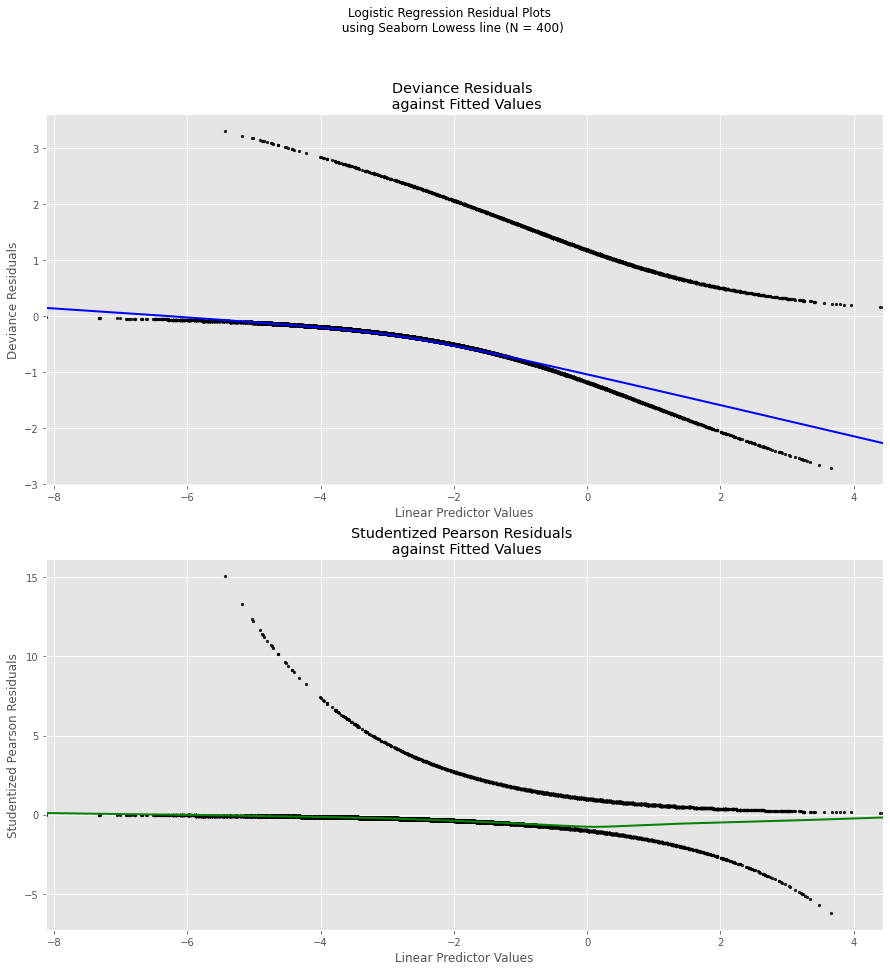

In [73]:
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

In [74]:
# The second graph looks flat and to have a y-intercept of close to 0 and so this condition is met

In [75]:
ll

['gender_female',
 'age_gt_45',
 'age_lt_25',
 'race_A',
 'race_O',
 're_discip_reports',
 're_escp_hist_3',
 'employed',
 'race_B',
 'off_1_gs_max',
 'off_1_prs_max',
 'prior_commits']

---

## Repeated but for overrides



In [85]:
ll.append('re_override_up')
ll

['gender_female',
 'age_gt_45',
 'age_lt_25',
 'race_A',
 'race_O',
 're_discip_reports',
 're_escp_hist_3',
 'employed',
 'race_B',
 'off_1_gs_max',
 'off_1_prs_max',
 'prior_commits',
 're_override_up']

In [87]:
df = pd.read_csv("../../data/re_custody_2017_gsprs.csv", low_memory=False)



# preprocessing
data = preprocessing.preprocess_input_vars_re(df)

data['high_re_discip_reports'] = np.where(data['re_discip_reports']>2, 1, 0)

data['re_override_up'] = np.where(data['re_ovride_cust_lvl']-data['re_custody_level']>0,1,0)
data['high_re'] = np.where(data['re_custody_level']>3, 1, 0)

data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        #"ic_custdy_level",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        "re_escp_hist_2",
        "re_escp_hist_3",
        "re_escp_hist_4",
        "re_escp_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "high_re_discip_reports",
        "high_re",
        "re_override_up"
    ]
]
data = data.dropna()

df_re_or = data[ll]

---
## Data exploration

In [88]:
df_re_or['re_override_up'].value_counts()

0    13746
1     2797
Name: re_override_up, dtype: int64

In [82]:
# I need to balance these classes
#!pip install imblearn

     |████████████████████████████████| 189 kB 2.3 MB/s eta 0:00:01


### Fitting a model (with oversampling to balance classes)

In [89]:
X = df_re_or.loc[:, df_re_or.columns != 're_override_up']
y = df_re_or.loc[:, df_re_or.columns == 're_override_up']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

os

SMOTE(random_state=0)

Counter({0: 9492, 1: 182})


In [90]:
X, y = os.fit_resample(X, y)

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

Optimization terminated successfully.
         Current function value: 0.474267
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.316     
Dependent Variable:  re_override_up   AIC:              26101.1122
Date:                2021-09-30 13:07 BIC:              26199.7720
No. Observations:    27492            Log-Likelihood:   -13039.   
Df Model:            11               LL-Null:          -19056.   
Df Residuals:        27480            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      8.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender_female     -1.8129   0.1394 -13.0053 0.0000 -2.0861 -1.5397
age_gt_45          0.3792   0.0321  11.7977 0.0000  0

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_os, y_train_os = os.fit_resample(X_train, y_train)


logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train_os, y_train_os.values.ravel())
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



Accuracy of logistic regression classifier on test set: 0.83


[[3229  892]
 [ 522 3605]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4121
           1       0.80      0.87      0.84      4127

    accuracy                           0.83      8248
   macro avg       0.83      0.83      0.83      8248
weighted avg       0.83      0.83      0.83      8248



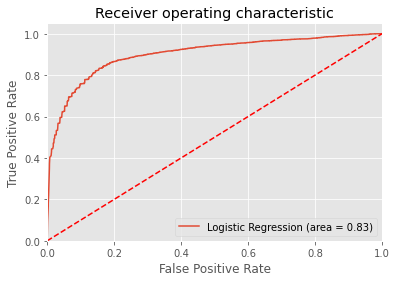

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()